# Evaluamos la proyección cartesiana de los datos

En este cuaderno se abordará la proyección de los datos desde su forma polar hacia su proyección cartesiana. Se evaluará tanto la resolución que debería usarse así como el tipo de interpolación.

In [2]:
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np
import warnings 

import utilidades as util

warnings.filterwarnings('ignore')

Si se recuerda, en un cuaderno anterior ya hemos visto una manera de proyectar. Para ello necesitamos algunos datos del radar.

In [3]:
radar_location = (-80.638333,-5.170278,56)
elevation = 2
azi,r = util.ejes()
r = r * 1000

Definimos la función de proyección: 

In [12]:
def proyectar(data, r, azi, res, radius=100000., ipol = wrl.ipol.Nearest, mask=False):
    "Función de proyección desde coordenadas rectangulares en (m y °) hacia una grilla polar de resolución res "
    polargrid = np.meshgrid(r, azi)
    coords, rad = wrl.georef.spherical_to_xyz(polargrid[0], polargrid[1],elevation, radar_location)
    x = coords[..., 0]
    y = coords[..., 1]
    spacing = 2*radius/res
    xgrid = np.linspace(x.min(), x.max(), spacing)
    ygrid = np.linspace(y.min(), y.max(), spacing)
    grid_xy = np.meshgrid(xgrid, ygrid)
    grid_xy = np.vstack((grid_xy[0].ravel(), grid_xy[1].ravel())).transpose()
    xy=np.concatenate([x.ravel()[:,None],y.ravel()[:,None]], axis=1)
    gridded = wrl.comp.togrid(src=xy, trg=grid_xy, radius=100000., center=np.array([x.mean(), y.mean()]),
                          data=data.ravel(), interpol=ipol)
    gridded = np.ma.masked_invalid(gridded).reshape((len(xgrid), len(ygrid)))
    if mask : 
        gridded = np.ma.masked_values(gridded, gridded.min())
    return xgrid, ygrid, gridded

Traemos los datos de ejemplo para realizar la proyección

In [10]:
datos, titles = util.testeo(explore=False)
data = datos[0]

Evaluaremos resoluciones de 1000 m típicas para radares como primera opción. 

In [13]:
x1000, y1000 , grid1000 = proyectar(data, r, azi,res=1000, ipol = wrl.ipol.Nearest)

Hacemos una pequeña función para ver los resultados

In [31]:
def gridplot(figure, gridded, xgrid, ygrid, number=111, n = 0.1):
    ax = figure.add_subplot(number, aspect="equal")
    pm = plt.pcolormesh(xgrid, ygrid, gridded)
    cbar = plt.colorbar(pm, shrink=0.75)
    cbar.set_label('Reflectividad [dBZ]')
    plt.title('Datos proyectados en la grilla')
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.xlim(n * min(xgrid), n * max(xgrid))
    plt.ylim(n * min(ygrid), n * max(ygrid))
    plt.grid(color="grey")
    return figure

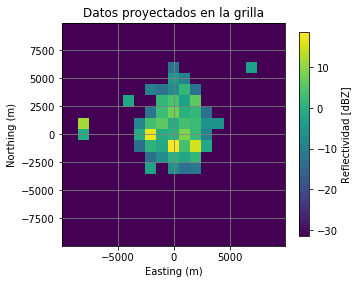

In [20]:
figure = plt.figure(figsize=(5,5))
figure = gridplot(figure,grid1000,x1000,y1000)

Si se fija en la escala, notará que este resultado ha subestimado los verdaderos valores de reflectividad. Veremos en cambio si usamos una resolución mayor, como por ejemplo 500 metros.

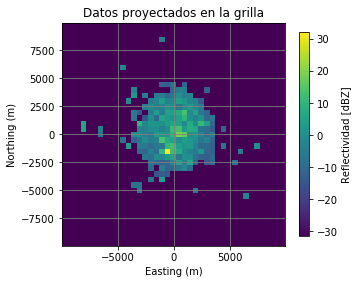

In [22]:
x500, y500 , grid500 = proyectar(data, r, azi, res=500, ipol = wrl.ipol.Nearest)
figure = plt.figure(figsize=(5,5))
figure = gridplot(figure, grid500, x500, y500)

Hacemos uno más usando 200 metros de resolución.

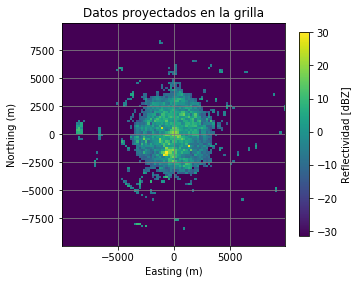

In [25]:
x200, y200 , grid200 = proyectar(data, r, azi, res=200, ipol = wrl.ipol.Nearest)
figure = plt.figure(figsize=(5,5))
figure = gridplot(figure, grid200, x200, y200)

Obviamente esta presentación está muy sesgada porque cerca del radar los datos tienen mucha resolución. Veremos que sucede en las lejanías.

In [26]:
data = datos[2]
x1000, y1000 , grid1000 = proyectar(data, r, azi,res=1000, ipol = wrl.ipol.Nearest)
x500, y500 , grid500 = proyectar(data, r, azi, res=500, ipol = wrl.ipol.Nearest)
x200, y200 , grid200 = proyectar(data, r, azi, res=200, ipol = wrl.ipol.Nearest)

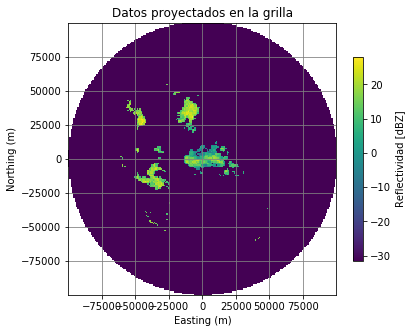

In [35]:
figure = plt.figure(figsize=(6,5))
figure = gridplot(figure,grid1000,x1000,y1000, n=1)

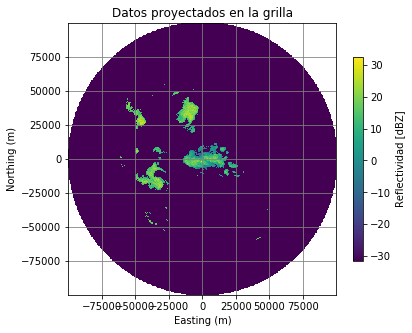

In [36]:
figure = plt.figure(figsize=(6,5))
figure = gridplot(figure, grid500, x500, y500, n=1)

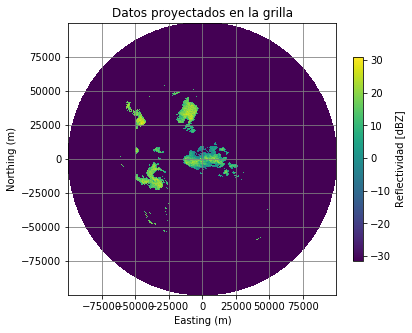

In [38]:
figure = plt.figure(figsize=(6,5))
figure = gridplot(figure, grid200, x200, y200, n=1)

Se puede probar cambiando los métodos de interpolación para probarlo también.